<a href="https://colab.research.google.com/github/Edd1enator/Tesis_Prediccion_Sequias/blob/main/ModeloKaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rasterio geopandas tensorflow scikit-image tqdm matplotlib -q
!apt install gdal-bin python3-gdal -qqq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 76.9 MB/s eta 0:00:00
Selecting previously unselected package python3-numpy.
(Reading database ... 125082 files and directories currently installed.)
Preparing to unpack .../python3-numpy_1%3a1.21.5-1ubuntu22.04.1_amd64.deb ...
Unpacking python3-numpy (1:1.21.5-1ubuntu22.04.1) ...
Selecting previously unselected package python3-gdal.
Preparing to unpack .../python3-gdal_3.8.4+dfsg-1~jammy0_amd64.deb ...
Unpacking python3-gdal (3.8.4+dfsg-1~jammy0) ...
Selecting previously unselected package gdal-bin.
Preparing to unpack .../gdal-bin_3.8.4+dfsg-1~jammy0_amd64.deb ...
Unpacking gdal-bin (3.8.4+dfsg-1~jammy0) ...
Setting up python3-numpy (1:1.21.5-1ubuntu22.04.1) ...
Setting up python3-gdal (3.8.4+dfsg-1~jammy0) ...
Setting up gdal-bin (3.8.4+dfsg-1~jammy0) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
from tensorflow import keras
import lightgbm as lgb
import joblib
from numpy import random
from sklearn.ensemble import RandomForestClassifier
import warnings

np.set_printoptions(linewidth=130)

warnings.filterwarnings('ignore')

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("Configurando GPUs...")
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    print("No se detectaron GPUs, usando CPU")

Configurando GPUs...


In [ ]:
try:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print(f"GPU detectada: {len(gpus)} dispositivos")
            print("Configuración de GPU optimizada")
        except RuntimeError as e:
            print(f"Error configurando GPU: {e}")
    else:
        print("No se detectó GPU")

    print(f"Versión de TensorFlow: {tf.__version__}")

except ImportError:
    print("Error en la configuración de aceleración")

GPU detectada: 1 dispositivos
Configuración de GPU optimizada
Versión de TensorFlow: 2.19.0


In [ ]:
base_path = "/content/drive/MyDrive/Tesis/DataKaggle"

train_path = os.path.join(base_path, "train_timeseries")
test_path = os.path.join(base_path, "test_timeseries")
validation_path = os.path.join(base_path, "validation_timeseries")
soil_data_path = os.path.join(base_path, "soil_data.csv")

OUTPUT_DIR = "/content/output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [ ]:
# Configurar rutas según tu estructura de carpetas
# base_path = "/Users/eddiegiron/Desktop/archive"

# train_path = os.path.join(base_path, "train_timeseries")
# test_path = os.path.join(base_path, "test_timeseries")
# validation_path = os.path.join(base_path, "validation_timeseries")
# soil_data_path = os.path.join(base_path, "soil_data.csv")

In [ ]:
batch_size = 1024
epochs = 50
random_state = 38
k_folds = 5
LEARNING_RATE = 3e-4

In [ ]:
mae_scores = []
r2_scores = []
models = []

In [ ]:
#@title Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Función de carga de datos
def carga_data(folder_path):
    all_files = []

    if os.path.exists(folder_path):
        for file in os.listdir(folder_path):
            if file.endswith('.csv'):
                file_path = os.path.join(folder_path, file)
                df = pd.read_csv(file_path)
                df['source_file'] = file
                all_files.append(df)

        if all_files:
            return pd.concat(all_files, ignore_index=True)
        else:
            print(f"No se encontraron archivos CSV en {folder_path}")
            return pd.DataFrame()
    else:
        print(f"La carpeta {folder_path} no existe")
        return pd.DataFrame()

In [ ]:
# Carga de datos para entorno
print("Cargando datos de entrenamiento...")
train_data = carga_data(train_path)

print("Cargando datos de prueba...")
test_data = carga_data(test_path)

print("Cargando datos de validación...")
validation_data = carga_data(validation_path)

print("Cargando datos del suelo...")
soil_data = pd.read_csv(soil_data_path) if os.path.exists(soil_data_path) else pd.DataFrame()

Cargando datos de entrenamiento...
Cargando datos de prueba...
Cargando datos de validación...
Cargando datos del suelo...


In [ ]:
# Limpieza de datos nulos en fips y date
train_data = train_data.dropna(subset=['fips', 'date'])
test_data = test_data.dropna(subset=['fips', 'date'])
validation_data = validation_data.dropna(subset=['fips', 'date'])

In [ ]:
print("=== ESTRUCTURA DE LOS DATOS ===")
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Validation data shape: {validation_data.shape}")
print(f"Soil data shape: {soil_data.shape}")

if not train_data.empty:
    print("\nColumnas en train_data:")
    print(train_data.columns.tolist())
    print("\nPrimeras filas de train_data:")
    print(train_data.head())

=== ESTRUCTURA DE LOS DATOS ===
Train data shape: (19300680, 22)
Test data shape: (2271948, 22)
Validation data shape: (2268840, 22)
Soil data shape: (3109, 32)

Columnas en train_data:
['fips', 'date', 'PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET', 'T2M_MAX', 'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX', 'WS10M_MIN', 'WS10M_RANGE', 'WS50M', 'WS50M_MAX', 'WS50M_MIN', 'WS50M_RANGE', 'score', 'source_file']

Primeras filas de train_data:
   fips        date  PRECTOT      PS   QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
0  1001  2000-01-01     0.22  100.51   9.65  14.74   13.51   13.51    20.96   
1  1001  2000-01-02     0.20  100.55  10.42  16.69   14.71   14.71    22.80   
2  1001  2000-01-03     3.65  100.15  11.76  18.49   16.52   16.52    22.73   
3  1001  2000-01-04    15.95  100.29   6.42  11.40    6.09    6.10    18.09   
4  1001  2000-01-05     0.00  101.15   2.95   3.86   -3.29   -3.20    10.82   

   T2M_MIN  ...  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  WS50M  WS50M_MA

In [ ]:
def visualizar_dataset(df, name):
    """Analiza un dataset mostrando información básica"""
    if df.empty:
        print(f"{name}: Dataset vacío")
        return

    print(f"\n=== ANÁLISIS DE {name.upper()} ===")
    print(f"Dimensiones: {df.shape}")
    print(f"Columnas: {df.columns.tolist()}")
    print(f"Tipos de datos:")
    print(df.dtypes)
    print(f"Valores nulos:")
    print(df.isnull().sum())

In [ ]:
visualizar_dataset(train_data, "train_data")
visualizar_dataset(soil_data, "soil_data")


=== ANÁLISIS DE TRAIN_DATA ===
Dimensiones: (19300680, 22)
Columnas: ['fips', 'date', 'PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET', 'T2M_MAX', 'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX', 'WS10M_MIN', 'WS10M_RANGE', 'WS50M', 'WS50M_MAX', 'WS50M_MIN', 'WS50M_RANGE', 'score', 'source_file']
Tipos de datos:
fips             int64
date            object
PRECTOT        float64
PS             float64
QV2M           float64
T2M            float64
T2MDEW         float64
T2MWET         float64
T2M_MAX        float64
T2M_MIN        float64
T2M_RANGE      float64
TS             float64
WS10M          float64
WS10M_MAX      float64
WS10M_MIN      float64
WS10M_RANGE    float64
WS50M          float64
WS50M_MAX      float64
WS50M_MIN      float64
WS50M_RANGE    float64
score          float64
source_file     object
dtype: object
Valores nulos:
fips                  0
date                  0
PRECTOT               0
PS                    0
QV2M                  0
T2M                   0
T

In [ ]:
def buscar_columna_objetivo(df):
    """Busca columnas relacionadas con sequía"""
    drought_keywords = ['drought', 'sequia', 'dry', 'aridity', 'water_stress', 'index']
    target_cols = []

    for col in df.columns:
        col_lower = col.lower()
        for keyword in drought_keywords:
            if keyword in col_lower:
                target_cols.append(col)
                break
    return target_cols

In [ ]:
target_columns = buscar_columna_objetivo(train_data)
print("Columnas objetivo potenciales:", target_columns)

if not target_columns and not train_data.empty:
    numeric_cols = train_data.select_dtypes(include=[np.number]).columns.tolist()
    print("Columnas numéricas disponibles:", numeric_cols)
    if numeric_cols:
        target_columns = [numeric_cols[-1]]
        print(f"Usando '{target_columns[0]}' como columna objetivo por defecto")

Columnas objetivo potenciales: []
Columnas numéricas disponibles: ['fips', 'PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET', 'T2M_MAX', 'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX', 'WS10M_MIN', 'WS10M_RANGE', 'WS50M', 'WS50M_MAX', 'WS50M_MIN', 'WS50M_RANGE', 'score']
Usando 'score' como columna objetivo por defecto


In [ ]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

print("✅ Configuración actualizada - Ahora puedes ver más registros")

# Probar de nuevo
train_data.score.head(100)

✅ Configuración actualizada - Ahora puedes ver más registros


,score
0,NaN
1,NaN
2,NaN
3,1.0000
4,NaN
5,NaN
6,NaN
7,NaN
8,NaN
9,NaN


In [ ]:
date_col = None
for c in ['date','fecha','timestamp','time']:
    if c in train_data.columns:
        date_col = c
        break
if date_col is None:
    raise ValueError("No encontré columna de fecha; asigna date_col manualmente.")

target_col = None
for c in train_data.columns:
    if 'score' in c.lower():
        target_col = c
        break
if target_col is None:
    raise ValueError("No encontré columna objetivo que contenga 'score' en su nombre.")

# normalizar fecha y ordenar
train_data[date_col] = pd.to_datetime(train_data[date_col], errors='coerce').dt.normalize()
train_data = train_data.dropna(subset=[date_col])
train_data = train_data.sort_values([ 'fips', date_col ]).reset_index(drop=True)

print("Datos cargados:", train_data.shape)
print("date_col:", date_col, "target_col:", target_col)

Datos cargados: (19300680, 22)
date_col: date target_col: score


In [ ]:
weekly_list = []
grouped = train_data.groupby('fips')

for fid, g in grouped:
    g = g.copy()
    g[date_col] = pd.to_datetime(g[date_col], errors='coerce').dt.normalize()
    g = g.set_index(date_col).sort_index()

    numeric_cols = g.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [c for c in numeric_cols if c != target_col]

    # construir series diarias promedio
    daily = g[numeric_cols].resample('D').mean()

    # agregar semanalmente con etiqueta el martes
    weekly = daily.resample('W-TUE').mean()

    score_s = g[[target_col]].dropna().groupby(level=0).first()

    wk = weekly.join(score_s, how='left')

    wk = wk.reset_index().rename(columns={'index': date_col})
    wk['fips'] = fid
    weekly_list.append(wk)

weekly_df = pd.concat(weekly_list, ignore_index=True)
weekly_df = weekly_df.rename(columns={date_col: 'date'})

print("weekly_df shape:", weekly_df.shape)
print(weekly_df[[ 'fips', 'date', target_col ]].head(10))


weekly_df shape: (2759904, 21)
   fips       date  score
0  1001 2000-01-04    1.0
1  1001 2000-01-11    2.0
2  1001 2000-01-18    2.0
3  1001 2000-01-25    2.0
4  1001 2000-02-01    1.0
5  1001 2000-02-08    1.0
6  1001 2000-02-15    1.0
7  1001 2000-02-22    1.0
8  1001 2000-02-29    1.0
9  1001 2000-03-07    1.0


In [ ]:
print(weekly_df.head(10))

        date  fips   PRECTOT          PS      QV2M        T2M     T2MDEW     T2MWET    T2M_MAX    T2M_MIN  T2M_RANGE         TS     WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE     WS50M  WS50M_MAX  WS50M_MIN  WS50M_RANGE  score
0 2000-01-04  1001  5.005000  100.375000  9.562500  15.330000  12.707500  12.710000  21.145000  10.387500  10.752500  15.242500  3.147500   4.342500   2.015000     2.330000  6.110000   7.750000   4.140000     3.615000    1.0
1 2000-01-11  1001  5.684286  100.665714  5.951429   9.192857   4.908571   4.934286  15.732857   3.071429  12.662857   8.558571  2.200000   3.305714   1.238571     2.065714  4.418571   6.588571   2.280000     4.307143    2.0
2 2000-01-18  1001  0.832857  101.275714  6.692857  10.118571   6.711429   6.735714  16.931429   3.757143  13.177143   9.975714  2.352857   3.257143   1.490000     1.767143  4.870000   6.508571   2.812857     3.692857    2.0
3 2000-01-25  1001  3.641429  100.187143  4.220000   4.458571  -0.224286  -0.132857  10.217143  -1.2

In [ ]:
def round_score_series(s):

    # Variable para almacenar valores score con NaN
    nan_mask = s.isna()

    rounded = np.floor(s.values + 0.5).astype(int)
    rounded = np.clip(rounded, 0, 5)

    result = pd.Series(rounded, index=s.index, dtype=float)

    # restaurar valores NaN
    result[nan_mask] = np.nan

    return result

In [ ]:
# df_temp = []
df_temp = weekly_df.copy()
df_temp['score'] = round_score_series(df_temp['score'])
print(df_temp)

              date   fips   PRECTOT          PS      QV2M        T2M     T2MDEW     T2MWET    T2M_MAX    T2M_MIN  T2M_RANGE         TS     WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE     WS50M  WS50M_MAX  WS50M_MIN  WS50M_RANGE  score
0       2000-01-04   1001  5.005000  100.375000  9.562500  15.330000  12.707500  12.710000  21.145000  10.387500  10.752500  15.242500  3.147500   4.342500   2.015000     2.330000  6.110000   7.750000   4.140000     3.615000    1.0
1       2000-01-11   1001  5.684286  100.665714  5.951429   9.192857   4.908571   4.934286  15.732857   3.071429  12.662857   8.558571  2.200000   3.305714   1.238571     2.065714  4.418571   6.588571   2.280000     4.307143    2.0
2       2000-01-18   1001  0.832857  101.275714  6.692857  10.118571   6.711429   6.735714  16.931429   3.757143  13.177143   9.975714  2.352857   3.257143   1.490000     1.767143  4.870000   6.508571   2.812857     3.692857    2.0
3       2000-01-25   1001  3.641429  100.187143  4.220000   4.458571  -0

In [ ]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

print("✅ Configuración actualizada - Ahora puedes ver más registros")

# Probar de nuevo
df_temp.score.head(100)
nulos_score = df_temp['score'].isna().sum()
print(nulos_score)

✅ Configuración actualizada - Ahora puedes ver más registros
3108


In [ ]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

print("✅ Configuración actualizada - Ahora puedes ver más registros")

# Probar de nuevo
df_temp.score.tail(100)

✅ Configuración actualizada - Ahora puedes ver más registros


,score
2759804,0.0
2759805,0.0
2759806,0.0
2759807,0.0
2759808,0.0
2759809,0.0
2759810,0.0
2759811,0.0
2759812,0.0
2759813,0.0


In [ ]:
# Función de preprocesamiento
def preprocess_data(df, target_col=None):
    if df.empty:
        return df, None, None

    df_processed = df.copy()

    date_columns = ['date', 'fecha', 'time', 'timestamp']
    for date_col in date_columns:
        if date_col in df_processed.columns:
            df_processed[date_col] = pd.to_datetime(df_processed[date_col], errors='coerce')
            df_processed['year'] = df_processed[date_col].dt.year
            df_processed['month'] = df_processed[date_col].dt.month
            df_processed['day'] = df_processed[date_col].dt.day
            break

    # Manejo de valores nulos
    numeric_cols = df_processed.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df_processed[col].isnull().sum() > 0:
            df_processed[col].fillna(df_processed[col].median(), inplace=True)

    no_numeric_cols = df_processed.select_dtypes(exclude=[np.number]).columns
    features_to_drop = [col for col in no_numeric_cols if col != target_col]
    df_processed = df_processed.drop(columns=features_to_drop)

    if target_col and target_col in df_processed.columns:
        X = df_processed.drop(columns=[target_col])
        y = df_processed[target_col]
        return X, y, df_processed
    else:
        return df_processed, None, df_processed


In [ ]:
# Preprocesar datos

columna_objetivo = buscar_columna_objetivo(df_temp)
# columna_objetivo = buscar_columna_objetivo(train_data)
columna_objetivo = columna_objetivo[0] if columna_objetivo else None

if not columna_objetivo and not df_temp.empty:
    numeric_cols = df_temp.select_dtypes(include=[np.number]).columns.tolist()
    if numeric_cols:
        columna_objetivo = numeric_cols[-1]
        print(f"Usando '{columna_objetivo}' como columna objetivo")

# if not columna_objetivo and not train_data.empty:
#     numeric_cols = train_data.select_dtypes(include=[np.number]).columns.tolist()
#     if numeric_cols:
#         columna_objetivo = numeric_cols[-1]
#         print(f"Usando '{columna_objetivo}' como columna objetivo")

print("Preprocesando datos...")
X_train, y_train, train_processed = preprocess_data(df_temp, columna_objetivo)
# X_train, y_train, train_processed = preprocess_data(train_data, columna_objetivo)
X_test, y_test, test_processed = preprocess_data(test_data, columna_objetivo)
X_val, y_val, val_processed = preprocess_data(validation_data, columna_objetivo)

Usando 'score' como columna objetivo
Preprocesando datos...


In [ ]:
print(y_val)

0          0.0
1          0.0
2          2.0
3          0.0
4          0.0
          ... 
2268835    0.0
2268836    0.0
2268837    0.0
2268838    0.0
2268839    0.0
Name: score, Length: 2268840, dtype: float64


In [ ]:
rf_fast = RandomForestRegressor(
    n_estimators=100,
    min_samples_leaf=5,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)

rf_fast.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', min_samples_leaf=5, n_jobs=-1,
                      random_state=42)

<Figure size 1000x800 with 0 Axes>

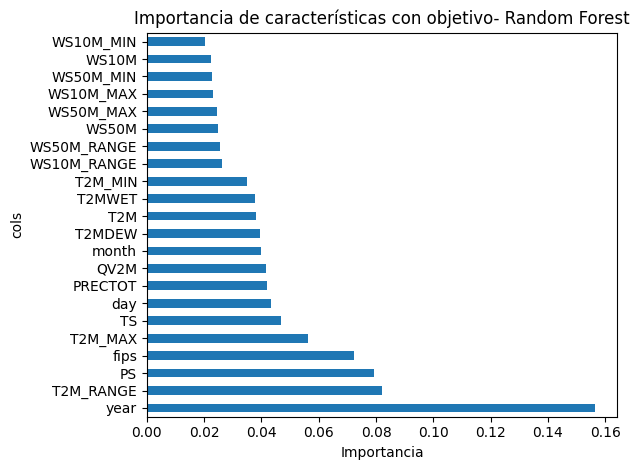

In [ ]:
importance_df = pd.DataFrame({
    'cols': X_train.columns,
    'imp': rf_fast.feature_importances_
}).sort_values('imp', ascending=False)

plt.figure(figsize=(10, 8))
importance_df.plot('cols', 'imp', 'barh', legend=False)
plt.title('Importancia de características con objetivo- Random Forest')
plt.xlabel('Importancia')
plt.tight_layout()
plt.show()

In [ ]:
# importance_df = pd.DataFrame({
#     'feature': X_train.columns,
#     'importance': rf.feature_importances_
# }).sort_values('importance', ascending=False)

# # Mostrar distribución de importancia
# print("Distribución de importancia:")
# print(importance_df['importance'].describe())

In [ ]:
# threshold_percentile = 0.95  # Mantener top 5% más importante
# threshold_value = importance_df['importance'].quantile(threshold_percentile)

# selected_features = importance_df[importance_df['importance'] >= threshold_value]['feature'].tolist()

# print(f"\n🔧 FILTRANDO CARACTERÍSTICAS:")
# print(f"Total original: {len(importance_df)} características")
# print(f"Seleccionadas: {len(selected_features)} características")
# print(f"Umbral de importancia: {threshold_value:.4f}")

# # Filtrar datasets
# X_train_filtered = X_train[selected_features]
# X_val_filtered = X_val[selected_features]

# print(f"\nCaracterísticas eliminadas: {len(importance_df) - len(selected_features)}")


In [ ]:
if y_train is not None and not X_train.empty:
    print(f"Datos listos: {X_train.shape[0]:,} ejemplos, {X_train.shape[1]} características")
else:
    print("Problema con los datos")
    if not train_data.empty:
        print("Columnas disponibles:", train_data.columns.tolist())

Datos listos: 2,759,904 ejemplos, 22 características


In [ ]:
# # Construir modelo de red neuronal
# def build_model(input_dim, learning_rate=LEARNING_RATE):
#     model = keras.Sequential([
#         # Capa de entrada con regularización
#         layers.Dense(512, activation='relu', input_shape=(input_dim,),
#                     kernel_regularizer=keras.regularizers.l2(0.0001)),
#         layers.BatchNormalization(),
#         layers.Dropout(0.3),

#         # Capas ocultas
#         layers.Dense(256, activation='relu',
#                     kernel_regularizer=keras.regularizers.l2(0.0001)),
#         layers.BatchNormalization(),
#         layers.Dropout(0.3),

#         layers.Dense(128, activation='relu'),
#         layers.Dropout(0.2),

#         layers.Dense(64, activation='relu'),
#         layers.Dropout(0.2),

#         # Capa de salida
#         layers.Dense(1, activation='linear')
#     ])

#     optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)

#     model.compile(
#         optimizer=optimizer,
#         loss='mse',
#         metrics=['mae', 'mse']
#     )

#     return model

In [ ]:
# # Entrenamiento de modelo
# if y_train is not None and not X_train.empty and not y_train.isnull().all():

#     # Escalado para redes neuronales
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.transform(X_test) if not X_test.empty else None
#     X_val_scaled = scaler.transform(X_val) if not X_val.empty else None

#     # Convertir a tensores TensorFlow para mejor rendimiento GPU
#     train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train.values))
#     train_dataset = train_dataset.batch(1024).prefetch(tf.data.AUTOTUNE)

#     if X_val_scaled is not None and y_val is not None:
#         val_dataset = tf.data.Dataset.from_tensor_slices((X_val_scaled, y_val.values))
#         val_dataset = val_dataset.batch(1024).prefetch(tf.data.AUTOTUNE)
#     else:
#         val_dataset = None

#     # Construcción del modelo
#     input_dim = X_train_scaled.shape[1]
#     model = build_model(input_dim)

#     print("Arquitectura del modelo:")
#     model.summary()

#     # Callbacks para entrenamiento eficiente
#     callbacks = [
#         EarlyStopping(patience=15, restore_best_weights=True, verbose=1),
#         ReduceLROnPlateau(factor=0.5, patience=10, verbose=1),
#         keras.callbacks.TensorBoard(log_dir='./logs', profile_batch=0)
#     ]

#     # Entrenamiento
#     print("Entrenando con GPU...")

#     history = model.fit(
#         train_dataset,
#         epochs=epochs,
#         validation_data=val_dataset,
#         callbacks=callbacks,
#         verbose=1
#     )

In [ ]:
# # Listas para almacenar resultados
# fold_no = 1
# acc_per_fold = []
# loss_per_fold = []
# precision_per_fold = []
# recall_per_fold = []
# f1_per_fold = []
# mae_per_fold = []
# r2_per_fold = []
# histories = []
# best_models = []
# training_times = []

# all_y_true = []
# all_y_pred = []
# all_y_pred_binary = []

# # Preparar datos completos
# X_train_full = X_train.values if hasattr(X_train, 'values') else X_train
# y_train_full = y_train.values if hasattr(y_train, 'values') else y_train

# # Configurar KFold
# kf = KFold(n_splits=k_folds, shuffle=True, random_state=random_state)

# # ------------------ BLOQUE K-FOLD REEMPLAZO (Pegar en lugar del existente) ------------------

# # Asegurar OUTPUT_DIR existe
# os.makedirs(OUTPUT_DIR, exist_ok=True)

# # Listas ya inicializadas arriba: acc_per_fold, mae_per_fold, r2_per_fold, histories, best_models, training_times, all_y_true, all_y_pred, all_y_pred_binary

# for train_index, val_index in kf.split(X_train_full, y_train_full):
#     print(f"\n Entrenando Fold #{fold_no}...")
#     start_time = time.time()

#     # Obtener datos de entrenamiento y validación para este fold
#     X_train_fold, X_val_fold = X_train_full[train_index], X_train_full[val_index]
#     y_train_fold, y_val_fold = y_train_full[train_index], y_train_full[val_index]

#     print(f"   Muestras entrenamiento: {len(X_train_fold):,}")
#     print(f"   Muestras validación: {len(X_val_fold):,}")

#     # Escalado por fold (IMPORTANTE para evitar data leakage)
#     scaler_fold = StandardScaler()
#     X_train_scaled_fold = scaler_fold.fit_transform(X_train_fold)
#     X_val_scaled_fold = scaler_fold.transform(X_val_fold)

#     # Crear datasets optimizados para GPU
#     train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled_fold, y_train_fold))
#     train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

#     val_dataset = tf.data.Dataset.from_tensor_slices((X_val_scaled_fold, y_val_fold))
#     val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

#     # Crear modelo usando la función build_model (centralizada)
#     input_dim = X_train_scaled_fold.shape[1]
#     model_fold = build_model(input_dim=input_dim, learning_rate=LEARNING_RATE)

#     # Callbacks para este fold - GUARDADO DE PESOS (save_weights_only=True)
#     checkpoint_path = os.path.join(OUTPUT_DIR, f'best_weights_fold_{fold_no}.weights.h5')
#     callbacks = [
#         tf.keras.callbacks.ModelCheckpoint(
#             checkpoint_path,
#             monitor='val_mae',           # optimizar MAE por ser tu métrica objetivo
#             save_best_only=True,
#             save_weights_only=True,
#             mode='min',
#             verbose=1
#         ),
#         tf.keras.callbacks.EarlyStopping(
#             monitor='val_mae',
#             patience=12,
#             restore_best_weights=True,
#             verbose=1
#         ),
#         tf.keras.callbacks.ReduceLROnPlateau(
#             monitor='val_mae',
#             factor=0.5,
#             patience=6,
#             min_lr=1e-6,
#             verbose=1
#         )
#     ]

#     # Entrenamiento del fold
#     print(f"   Iniciando entrenamiento ({epochs} épocas máx)...")
#     history = model_fold.fit(
#         train_dataset,
#         epochs=epochs,
#         validation_data=val_dataset,
#         callbacks=callbacks,
#         verbose=1
#     )

#     # Guardar historial
#     histories.append(history.history)

#     # Cargar los mejores pesos guardados por ModelCheckpoint (si existen)
#     if os.path.exists(checkpoint_path):
#         try:
#             model_fold.load_weights(checkpoint_path)
#             print(f"   Pesos cargados desde {checkpoint_path}")
#         except Exception as e:
#             print("   Warning: fallo al cargar pesos con load_weights:", e)

#     # Evaluación sobre el conjunto de validación del fold
#     print(f"   Evaluando Fold #{fold_no}...")
#     # .evaluate devuelve [loss, mae, mse] si tu model.metrics definidas así
#     val_metrics = model_fold.evaluate(X_val_scaled_fold, y_val_fold, verbose=0)
#     # Intenta mapear métricas devueltas (loss, mae, mse) — si la firma cambia, ajusta índices
#     try:
#         val_loss = float(val_metrics[0])
#         val_mae = float(val_metrics[1]) if len(val_metrics) > 1 else mean_absolute_error(y_val_fold, model_fold.predict(X_val_scaled_fold).ravel())
#     except Exception:
#         val_loss = float(val_metrics)
#         val_mae = mean_absolute_error(y_val_fold, model_fold.predict(X_val_scaled_fold).ravel())

#     # Predicciones para métricas adicionales
#     y_val_pred = model_fold.predict(X_val_scaled_fold, verbose=0).flatten()

#     # Acumular predicciones y etiquetas reales (como listas)
#     all_y_true.extend(np.array(y_val_fold).ravel().tolist())
#     all_y_pred.extend(y_val_pred.ravel().tolist())

#     # Calcular métricas sklearn
#     from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
#     val_mae_sk = mean_absolute_error(y_val_fold, y_val_pred)
#     val_mse_sk = mean_squared_error(y_val_fold, y_val_pred)
#     val_r2 = r2_score(y_val_fold, y_val_pred)

#     # Determinar si es clasificación binaria (usando unique en y_train_full)
#     unique_values = np.unique(y_train_full)
#     if len(unique_values) == 2 and np.max(unique_values) == 1 and np.min(unique_values) == 0:
#         # Clasificación binaria: convertir por umbral (0.5)
#         from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#         y_val_pred_binary = (y_val_pred > 0.5).astype(int)
#         all_y_pred_binary.extend(y_val_pred_binary.tolist())

#         val_acc = accuracy_score(y_val_fold, y_val_pred_binary)
#         val_precision = precision_score(y_val_fold, y_val_pred_binary, average='binary', zero_division=0)
#         val_recall = recall_score(y_val_fold, y_val_pred_binary, average='binary', zero_division=0)
#         val_f1 = f1_score(y_val_fold, y_val_pred_binary, average='binary', zero_division=0)
#     else:
#         # Regresión - usar R² como "acc" placeholder para reporting (como hacías antes)
#         val_acc = val_r2
#         val_precision = val_r2
#         val_recall = val_r2
#         val_f1 = val_r2

#     # Medir tiempo
#     training_time = time.time() - start_time
#     training_times.append(training_time)

#     # Mostrar resultados
#     print(f"\n    Resultados Fold #{fold_no}:")
#     print(f"      Tiempo entrenamiento: {training_time:.2f}s")
#     print(f"      Loss (reported): {val_loss:.4f}")
#     print(f"      MAE (sklearn): {val_mae_sk:.4f}")
#     print(f"      R²: {val_r2:.4f}")

#     if len(unique_values) == 2:
#         print(f"      Accuracy: {val_acc:.4f}")
#         print(f"      Precision: {val_precision:.4f}")
#         print(f"      Recall: {val_recall:.4f}")
#         print(f"      F1-Score: {val_f1:.4f}")

#     # Guardar resultados en listas
#     acc_per_fold.append(val_acc)
#     loss_per_fold.append(val_loss)
#     precision_per_fold.append(val_precision)
#     recall_per_fold.append(val_recall)
#     f1_per_fold.append(val_f1)
#     mae_per_fold.append(val_mae_sk)
#     r2_per_fold.append(val_r2)

#     # Guardar la ruta de los mejores pesos de este fold (no el objeto modelo)
#     best_models.append(checkpoint_path)

#     # Guardar el scaler de este fold
#     import joblib
#     joblib.dump(scaler_fold, os.path.join(OUTPUT_DIR, f'scaler_fold_{fold_no}.pkl'))

#     # Limpieza de memoria
#     del model_fold, scaler_fold
#     tf.keras.backend.clear_session()
#     import gc
#     gc.collect()

#     fold_no += 1


In [ ]:
# # Función para matriz de confusión
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# def plot_confusion_from_preds(y_true_list, y_pred_list, method='auto', threshold=None, bins=None,
#                               normalize=False, show_custom_plot=True, save_path=None):

#     import pandas as pd
#     y_true = np.array(y_true_list).ravel()
#     y_pred = np.array(y_pred_list).ravel()
#     if len(y_true) != len(y_pred):
#         raise ValueError("y_true y y_pred deben tener la misma longitud")

#     if bins is not None:
#         y_true_bin = pd.cut(y_true, bins=bins, labels=False)
#         y_pred_bin = pd.cut(y_pred, bins=bins, labels=False)
#         labels = np.unique(np.concatenate([y_true_bin, y_pred_bin]))
#     else:
#         if threshold is None:
#             if set(np.unique(y_true)).issubset({0,1}):
#                 threshold = 0.5
#             else:
#                 threshold = np.median(y_true)
#         y_true_bin = (y_true >= threshold).astype(int)
#         y_pred_bin = (y_pred >= threshold).astype(int)
#         labels = np.array([0,1])

#     # Matrices
#     cm_norm = confusion_matrix(y_true_bin, y_pred_bin, labels=labels, normalize='pred' if normalize else None)
#     cm_raw = confusion_matrix(y_true_bin, y_pred_bin, labels=labels, normalize=None)

#     # Reporte
#     print(f"Muestras: {len(y_true)} -- Método: {method} -- threshold: {threshold}")
#     try:
#         print("\nClassification report (sobre clases discretizadas):\n")
#         print(classification_report(y_true_bin, y_pred_bin, zero_division=0))
#     except Exception as e:
#         print("No se pudo generar classification_report:", e)

#     if len(labels) == 2:
#         tn, fp, fn, tp = cm_raw.ravel()
#         acc = accuracy_score(y_true_bin, y_pred_bin)
#         prec = precision_score(y_true_bin, y_pred_bin, zero_division=0)
#         rec = recall_score(y_true_bin, y_pred_bin, zero_division=0)
#         f1 = f1_score(y_true_bin, y_pred_bin, zero_division=0)
#         print(f"TP={tp}, FP={fp}, FN={fn}, TN={tn}")
#         print(f"Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}")
#     else:
#         print("Multiclase detectado. Mostrar conteos por clase en la matriz.")

#     # Heatmap
#     plt.figure(figsize=(6,5))
#     target_cm = cm_norm if (normalize and cm_norm is not None) else cm_raw
#     fmt = '.2f' if normalize else 'd'
#     sns.heatmap(target_cm, annot=True, fmt=fmt, xticklabels=labels, yticklabels=labels, cmap='Blues')
#     plt.xlabel('Predicción')
#     plt.ylabel('Real')
#     plt.title(f'Matriz de confusión ({len(y_true)} muestras)')
#     if save_path:
#         plt.savefig(save_path, bbox_inches='tight', dpi=150)
#         print(f"Figura guardada en: {save_path}")
#     plt.show()

#     if show_custom_plot and len(labels) == 2:
#         tn, fp, fn, tp = cm_raw.ravel()
#         def plot_custom_2x2(tp, fp, fn, tn, title='Matriz de confusión personalizada'):
#             mat = np.array([[tp, fp],[fn, tn]])
#             colors = np.array([['#3a7a2e', '#d22b2b'], ['#d22b2b', '#3a7a2e']])
#             fig, ax = plt.subplots(figsize=(6,6))
#             for i in range(2):
#                 for j in range(2):
#                     ax.add_patch(plt.Rectangle((j, 1-i), 1, 1, color=colors[i,j], ec='navy', lw=1))
#                     if i==0 and j==0:
#                         text = f"Verdaderos\nPositivos\n\n{mat[i,j]}"
#                     elif i==0 and j==1:
#                         text = f"Falsos\nPositivos\n\n{mat[i,j]}"
#                     elif i==1 and j==0:
#                         text = f"Falsos\nNegativos\n\n{mat[i,j]}"
#                     else:
#                         text = f"Verdaderos\nNegativos\n\n{mat[i,j]}"
#                     ax.text(j+0.5, 1-i+0.5, text, ha='center', va='center', color='white', fontsize=14)
#             ax.set_xlim(0,2); ax.set_ylim(0,2)
#             ax.set_xticks([0.5, 1.5]); ax.set_xticklabels(['VALORES REALES\nPositivo','VALORES REALES\nNegativo'], fontsize=10)
#             ax.set_yticks([1.5, 0.5]); ax.set_yticklabels(['VALORES PREDICCIÓN\nPositivo','VALORES PREDICCIÓN\nNegativo'], fontsize=10)
#             ax.invert_yaxis()
#             ax.set_title(title, pad=20)
#             ax.axis('off')
#             plt.show()
#         plot_custom_2x2(tp=tp, fp=fp, fn=fn, tn=tn)

#     return {'cm': cm_raw, 'cm_norm': cm_norm, 'labels': labels, 'y_true_bin': y_true_bin, 'y_pred_bin': y_pred_bin}

# # Ejecución automática si detecta listas globales con nombres comunes
# try:
#     if 'all_y_true' in globals() and 'all_y_pred' in globals():
#         print("Ejecutando plot_confusion_from_preds con all_y_true / all_y_pred del notebook...")
#         _ = plot_confusion_from_preds(all_y_true, all_y_pred, method='auto', threshold=None, bins=None, normalize=False, show_custom_plot=True)
#     else:
#         print("No se detectaron all_y_true/all_y_pred en globals(). Llama a plot_confusion_from_preds manualmente.")
# except Exception as e:
#     print("Error al ejecutar la función automáticamente:", e)


In [ ]:
# print(unique_values)
# print(y_train_full)
# print(y_train)

In [ ]:
# print("\n" + "="*70)
# print(" RESUMEN FINAL K-FOLD CROSS VALIDATION")
# print("="*70)

# print(f" Precisión/R² promedio: {np.mean(acc_per_fold):.4f} (+/- {np.std(acc_per_fold):.4f})")
# print(f" Loss promedio: {np.mean(loss_per_fold):.4f} (+/- {np.std(loss_per_fold):.4f})")
# print(f" MAE promedio: {np.mean(mae_per_fold):.4f} (+/- {np.std(mae_per_fold):.4f})")
# print(f" R² promedio: {np.mean(r2_per_fold):.4f} (+/- {np.std(r2_per_fold):.4f})")
# print(f" Tiempo promedio por fold: {np.mean(training_times):.2f}s")

# if len(np.unique(y_train_full)) == 2:
#     print(f" Precision promedio: {np.mean(precision_per_fold):.4f} (+/- {np.std(precision_per_fold):.4f})")
#     print(f" Recall promedio: {np.mean(recall_per_fold):.4f} (+/- {np.std(recall_per_fold):.4f})")
#     print(f" F1-Score promedio: {np.mean(f1_per_fold):.4f} (+/- {np.std(f1_per_fold):.4f})")

# print(f"\n Métricas por Fold:")
# for i, (acc, loss, mae, r2) in enumerate(zip(acc_per_fold, loss_per_fold, mae_per_fold, r2_per_fold), 1):
#     if len(np.unique(y_train_full)) == 2:
#         prec = precision_per_fold[i-1]
#         rec = recall_per_fold[i-1]
#         f1 = f1_per_fold[i-1]
#         print(f"  Fold {i}: Acc={acc:.4f}, Loss={loss:.4f}, Prec={prec:.4f}, Rec={rec:.4f}, F1={f1:.4f}")
#     else:
#         print(f"  Fold {i}: R²={r2:.4f}, Loss={loss:.4f}, MAE={mae:.4f}")

# # Análisis de estabilidad
# acc_std = np.std(acc_per_fold)
# print(f"\n ANÁLISIS DE ESTABILIDAD:")
# print(f"   Desviación estándar entre folds: {acc_std:.4f}")

# if acc_std < 0.02:
#     print("   Modelo muy estable - Excelente consistencia entre folds")
# elif acc_std < 0.05:
#     print("   Modelo estable - Buena consistencia")
# elif acc_std < 0.1:
#     print("    Modelo moderadamente estable")
# else:
#     print("    Modelo muestra alta variabilidad - Revisar datos/arquitectura")

# # MATRIZ DE CONFUSIÓN AGREGADA (si es clasificación binaria)
# if len(np.unique(y_train_full)) == 2 and len(y_true_agg) > 0:
#     try:
#         y_true_all = np.concatenate(y_true_agg)
#         y_pred_all = np.concatenate(y_pred_agg)
#         cm_all = confusion_matrix(y_true_all, y_pred_all)
#         print("\nMatriz de confusión agregada (todos los folds):")
#         print(cm_all)

#         try:
#             plt.figure(figsize=(6,5))
#             sns.heatmap(cm_all, annot=True, fmt='d', cmap='Blues', cbar=False)
#             plt.title('Confusion Matrix - All Folds')
#             plt.xlabel('Predicted')
#             plt.ylabel('Actual')
#             plt.tight_layout()
#             plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_all_folds.png'))
#             plt.close()
#             print(f"  Matriz agregada guardada en: {os.path.join(OUTPUT_DIR, 'confusion_all_folds.png')}")
#         except Exception as e:
#             print(f"  No se pudo generar el gráfico de la matriz agregada: {e}")
#     except Exception as e:
#         print(f"  Error calculando matriz de confusión agregada: {e}")

# # Guardar resultados en variables globales para uso posterior
# kfold_results = {
#     'acc_scores': acc_per_fold,
#     'loss_scores': loss_per_fold,
#     'precision_scores': precision_per_fold,
#     'recall_scores': recall_per_fold,
#     'f1_scores': f1_per_fold,
#     'mae_scores': mae_per_fold,
#     'r2_scores': r2_per_fold,
#     'histories': histories,
#     'best_models': best_models,
#     'training_times': training_times
# }

# print(f"\n K-Fold completado exitosamente!")
# print(f" Modelos guardados en: {OUTPUT_DIR}")

In [ ]:
# Entrenamiento de modelo LightGBM

# X_sub, X_val_sub, y_sub, y_val_sub = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# dtrain = lgb.Dataset(X_sub, label=y_sub)
# dvalid = lgb.Dataset(X_val_sub, label=y_val_sub, reference=dtrain)

kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'learning_rate': 0.03,
    'num_leaves': 127,
    'max_depth': -1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_data_in_leaf': 50,
    'lambda_l1': 0.0,
    'lambda_l2': 1.0,
    'verbose': -1
    # 'objective':'regression',
    # 'metric':'mae',
    # 'learning_rate': 0.03,
    # 'num_leaves': 127,
    # 'max_depth': 12,
    # 'min_data_in_leaf': 50,
    # 'feature_fraction': 0.8,
    # 'bagging_fraction': 0.8,
    # 'verbose': -1

}

# bst = lgb.train(
#     params,
#     dtrain,
#     num_boost_round=5000,
#     valid_sets=[dtrain, dvalid],
#     valid_names=['train','valid'],
#     callbacks=[
#         lgb.early_stopping(stopping_rounds=100),
#         lgb.log_evaluation(period=100)
#     ]
# )

# y_pred = bst.predict(X_val_sub, num_iteration=bst.best_iteration)
# print("MAE", mean_absolute_error(y_val_sub, y_pred), "R2", r2_score(y_val_sub, y_pred))


In [ ]:
models = []
mae_scores = []
r2_scores = []
oof_predictions = np.zeros(len(X_train))

In [ ]:
print(f"Iniciando entrenamiento con {k_folds}-Fold Cross-Validation\n")

# Iteración sobre cada fold
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train), 1):
    print(f"{'='*60}")
    print(f"Fold {fold}/{k_folds}")
    print(f"{'='*60}")

    # Dividir datos
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Crear datasets de LightGBM
    dtrain = lgb.Dataset(X_fold_train, label=y_fold_train)
    dvalid = lgb.Dataset(X_fold_val, label=y_fold_val, reference=dtrain)

    # Entrenar modelo
    bst = lgb.train(
        params,
        dtrain,
        num_boost_round=5000,
        valid_sets=[dtrain, dvalid],
        valid_names=['train', 'valid'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=100)
        ]
    )

    # Predicciones en validación
    y_pred = bst.predict(X_fold_val, num_iteration=bst.best_iteration)

    # Guardar predicciones out-of-fold
    oof_predictions[val_idx] = y_pred

    # Calcular métricas
    mae = mean_absolute_error(y_fold_val, y_pred)
    r2 = r2_score(y_fold_val, y_pred)

    mae_scores.append(mae)
    r2_scores.append(r2)
    models.append(bst)

    print(f"\nFold {fold} - MAE: {mae:.4f}, R²: {r2:.4f}")
    print(f"Best iteration: {bst.best_iteration}\n")


Iniciando entrenamiento con 5-Fold Cross-Validation

Fold 1/5
Training until validation scores don't improve for 100 rounds
[100]	train's l1: 0.686579	valid's l1: 0.688271
[200]	train's l1: 0.59947	valid's l1: 0.602109
[300]	train's l1: 0.558775	valid's l1: 0.562049
[400]	train's l1: 0.532848	valid's l1: 0.536759
[500]	train's l1: 0.51358	valid's l1: 0.518132
[600]	train's l1: 0.498675	valid's l1: 0.503874
[700]	train's l1: 0.486883	valid's l1: 0.492668
[800]	train's l1: 0.476906	valid's l1: 0.483191
[900]	train's l1: 0.467963	valid's l1: 0.47484
[1000]	train's l1: 0.459862	valid's l1: 0.467238
[1100]	train's l1: 0.452947	valid's l1: 0.460864
[1200]	train's l1: 0.44649	valid's l1: 0.454921
[1300]	train's l1: 0.440312	valid's l1: 0.449258
[1400]	train's l1: 0.434639	valid's l1: 0.444036
[1500]	train's l1: 0.429604	valid's l1: 0.439505
[1600]	train's l1: 0.425245	valid's l1: 0.435635
[1700]	train's l1: 0.420538	valid's l1: 0.431385
[1800]	train's l1: 0.416301	valid's l1: 0.427624
[1900]	

In [ ]:
# Resultados finales
print(f"\n{'='*60}")
print("RESULTADOS FINALES")
print(f"{'='*60}")
print(f"MAE promedio: {np.mean(mae_scores):.4f} (+/- {np.std(mae_scores):.4f})")
print(f"R² promedio:  {np.mean(r2_scores):.4f} (+/- {np.std(r2_scores):.4f})")

# Métricas con predicciones out-of-fold
oof_mae = mean_absolute_error(y_train, oof_predictions)
oof_r2 = r2_score(y_train, oof_predictions)
print(f"\nOut-of-Fold MAE: {oof_mae:.4f}")
print(f"Out-of-Fold R²:  {oof_r2:.4f}")

print("\nMétricas por fold:")
for i, (mae, r2) in enumerate(zip(mae_scores, r2_scores), 1):
    print(f"  Fold {i}: MAE={mae:.4f}, R²={r2:.4f}")

# Función para hacer predicciones con ensemble (promedio de todos los modelos)
def predict_ensemble(models, X):
    """Predice usando el promedio de todos los modelos"""
    predictions = np.zeros((len(X), len(models)))
    for i, model in enumerate(models):
        predictions[:, i] = model.predict(X, num_iteration=model.best_iteration)
    return predictions.mean(axis=1)

# Ejemplo de uso para predicción en test
# y_test_pred = predict_ensemble(models, X_test)

print(f"\n{len(models)} modelos entrenados y guardados en la lista 'models'")


RESULTADOS FINALES
MAE promedio: 0.3641 (+/- 0.0005)
R² promedio:  0.8239 (+/- 0.0005)

Out-of-Fold MAE: 0.3641
Out-of-Fold R²:  0.8239

Métricas por fold:
  Fold 1: MAE=0.3644, R²=0.8233
  Fold 2: MAE=0.3631, R²=0.8242
  Fold 3: MAE=0.3643, R²=0.8244
  Fold 4: MAE=0.3642, R²=0.8244
  Fold 5: MAE=0.3644, R²=0.8233

5 modelos entrenados y guardados en la lista 'models'
